In [283]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import signal
import math
from scipy.signal import fftconvolve
from scipy.fft import fft

In [114]:
"""
1. Load dataset
2. Run algorithms
3. Run pitch algorithms
4. Compare rmse and computational time
"""

'\n1. Load dataset\n2. Run algorithms\n3. Run pitch algorithms\n4. Compare rmse and computational time\n'

## Load audio

In [54]:
# Generate a test sine wave with "N" octave frequency changes, all with amplityde = 1

def gen_sine_test(f0, N, dur, fs):
    # f0 = base frequency, N = octave multiplier, dur = Duration of each note, fs = sampling rate
    
    test_wave = np.array([])
    t_init = 0
    for wave_num in np.arange(1, N+1):
        f1 = f0*wave_num
        t = np.arange(t_init, t_init + dur, 1./fs)
        wave = np.sin(2*np.pi*f1*t)
        t_init = t_init + dur
        test_wave = np.append(test_wave, wave)
        
    return test_wave

In [165]:
f0 = 1000
N = 3
dur = 1
fs = 44100
x = gen_sine_test(f0, N, dur, fs)
x = x.astype('float64')

In [91]:
blockSize = 2048
hopSize = blockSize//4

In [92]:
f, t, X = scipy.signal.spectrogram(x, fs, window=('hanning'), nperseg=blockSize, noverlap=hopSize, nfft=blockSize, detrend='constant', return_onesided=True, scaling='density', axis=- 1, mode='psd')

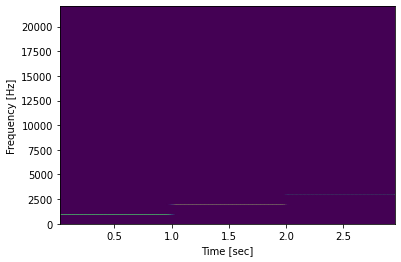

In [93]:
plt.pcolormesh(t, f, X, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [157]:
def  block_audio(x,blockSize,hopSize,fs):    
    # allocate memory    
    numBlocks = math.ceil(x.size / hopSize)    
    xb = np.zeros([numBlocks, blockSize])    
    # compute time stamps    
    t = (np.arange(0, numBlocks) * hopSize) / fs    
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)    
    for n in range(0, numBlocks):        
        i_start = n * hopSize        
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])        
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]    
    return (xb,t)

In [221]:
blockSize = 2048
hopSize = blockSize//2
fs = 44100
xb, t = block_audio(x,blockSize,hopSize,fs)

## Autocorrelation

In [222]:
# Nitin's acf

## YIN

In [261]:
def YIN_diff_function_conv(block, f0min, fs):
    f0min = 50
    tau_max = fs//f0min
    w = block.size
    block_cumsum = np.concatenate((np.array([0]), (block * block).cumsum()))
    conv = fftconvolve(block, block[::-1])
    tmp = block_cumsum[w:0:-1] + block_cumsum[w] - block_cumsum[:w] - 2*conv[w-1:]
    #return tmp[:tau_max+1]
    return tmp

def CMND_YIN(d, N):
    """
    Compute cumulative mean normalized difference function (CMND).
    df: Difference function
    N: length of data
    Return: cumulative mean normalized difference function
    """

    cmndf = d[1:] * range(1, N) / np.cumsum(d[1:]).astype(float) #scipy method
    return np.insert(cmndf, 0, 1)

def getPitch(cmdf, tau_min, tau_max, harmo_th=0.1):
    """
    Return fundamental period of a frame based on CMND function.
    :param tau_min: minimum period of utterance
    :param tau_max: maximum period of utterance
    :param harmo_th: harmonicity threshold to determine if it is necessary to compute pitch frequency
    :return: fundamental period if there is values under threshold, 0 otherwise
    """
    tau = tau_min
    while tau < tau_max:
        if cmdf[tau] < harmo_th:
            while tau + 1 < tau_max and cmdf[tau + 1] < cmdf[tau]:
                tau += 1
            return tau
        tau += 1

    return 0    # if unvoiced

In [262]:
block = xb[0]
f0min = 50
f0max = 2000
tau_min = fs//f0max
tau_max = fs//f0min
harmo_th = 0.1

d = YIN_diff_function_conv(block, f0min, fs)

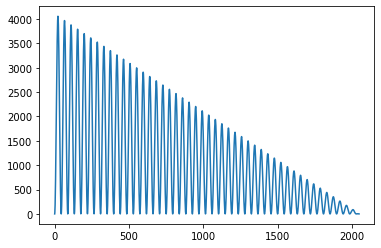

In [263]:
plt.plot(d)

In [269]:
cmdf = CMND_YIN(d, len(block))

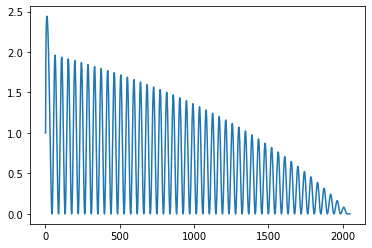

In [270]:
plt.plot(cmdf)

In [266]:
pitch = getPitch(cmdf, tau_min, tau_max, harmo_th=0.1)

In [268]:
pitch

44

(2048,)

(array([  0,   1, 282, 326, 442]),)


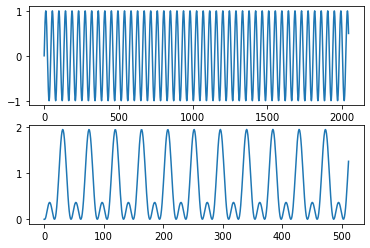

In [94]:
W = 511
w = np.hamming(W)
w = w / sum(w)

"""
d(j, tau) = (1/W) * summation(j=1:W)(x[j]-x[j+tau])**2
"""

d = np.zeros([])

#Difference function
for tau in range(W):
    for j in range(W):
        diff = (x[j] - x[j + tau])**2
    d = np.append(d, diff)
# print (d)

tp_temp = np.where(d < 0.0001)
print (tp_temp)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(x[:blockSize])

ax2 = fig.add_subplot(212)
ax2.plot(d)
plt.show()

In [95]:
locs = np.array([])
for i, test in enumerate(d):
    if i == 0 or i == len(d):
        i = i
    if i > 0:
        if d[i] < d[i-1] and d[i] < d[i+1]:
            locs = np.append(locs, i)

In [96]:
print (locs)
print (np.diff(locs))

[ 17.  45.  61.  89. 106. 133. 150. 177. 194. 222. 238. 266. 282. 310.
 326. 354. 370. 398. 414. 442. 458. 486. 502.]
[28. 16. 28. 17. 27. 17. 27. 17. 28. 16. 28. 16. 28. 16. 28. 16. 28. 16.
 28. 16. 28. 16.]


In [101]:
fs/np.diff(locs)[3]

2594.1176470588234

In [117]:
A = np.arange(10)
np.cumsum(A)

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])

In [130]:
print (A[1:])
print (A[1:]*range(1, 10))

[1 2 3 4 5 6 7 8 9]
[ 1  4  9 16 25 36 49 64 81]


In [514]:
def compute_yin(x, sr=44100, dataFileName=None, blockSize=512, hopSize=256, f0_min=100, f0_max=2000, harmo_thresh=0.1):
    """
    Compute the Yin Algorithm. Return fundamental frequency and harmonic rate.
    :param sig: Audio signal (list of float)
    :param sr: sampling rate (int)
    :param w_len: size of the analysis window (samples)
    :param w_step: size of the lag between two consecutives windows (samples)
    :param f0_min: Minimum fundamental frequency that can be detected (hertz)
    :param f0_max: Maximum fundamental frequency that can be detected (hertz)
    :param harmo_tresh: Threshold of detection. The yalgorithmù return the first minimum of the CMND fubction below this treshold.
    :returns:
        * pitches: list of fundamental frequencies,
        * harmonic_rates: list of harmonic rate values for each fundamental frequency value (= confidence value)
        * argmins: minimums of the Cumulative Mean Normalized DifferenceFunction
        * times: list of time of each estimation
    :rtype: tuple
    """

    print('Yin: compute yin algorithm')
    tau_min = int(sr / f0_max)
    tau_max = int(sr / f0_min)
    
    frames, timeInSec = block_audio(x, blockSize, hopSize, fs)

    pitches = np.zeros(len(timeInSec))
    harmonic_rates = np.zeros(len(timeInSec))
    argmins = np.zeros(len(timeInSec))

    for i, frame in enumerate(frames):

        print (i)
        #Compute YIN
        df, W = differenceFunction(frame)#CMND_YIN(d, N)
        cmdf = CMND_YIN(df, W)
        p = getPitch(cmdf, tau_min, tau_max, harmo_thresh)

        #Get results
        if np.argmin(cmdf)>tau_min:
            argmins[i] = float(sr / np.argmin(cmdf))
        if p != 0: # A pitch was found
            pitches[i] = float(sr / p)
            harmonic_rates[i] = cmdf[p]
        else: # No pitch, but we compute a value of the harmonic rate
            harmonic_rates[i] = min(cmdf)

    return pitches, harmonic_rates, argmins

In [515]:
f_YIN, harmonic_YIN, argmins_YIN = compute_yin(x, fs, blockSize=2048, hopSize=blockSize//2, f0_min=100, f0_max=2000, harmo_thresh=0.1)

Yin: compute yin algorithm
0
1


/Users/saksham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


## Two way mismatch

In [506]:
def dft(x, w, N):
    """
    Analysis of a signal using the discrete Fourier transform
    x: input signal, w: analysis window, N: FFT size
    returns mX, pX: magnitude and phase spectrum
    """

    hN = (N // 2) + 1                                           # size of positive spectrum, it includes sample 0
    hM1 = (w.size + 1) // 2                                     # half analysis window size by rounding
    hM2 = w.size // 2                                         # half analysis window size by floor
    fftbuffer = np.zeros(N)                                 # initialize buffer for FFT
    w = w / sum(w)                                          # normalize analysis window
    xw = x * w                                                # window the input sound
    fftbuffer[:hM1] = xw[hM2:]                              # zero-phase window in fftbuffer
    fftbuffer[-hM2:] = xw[:hM2]
    X = fft(fftbuffer)                                      # compute FFT
    absX = abs(X[:hN])                                      # compute ansolute value of positive side
    absX[absX < np.finfo(float).eps] = np.finfo(float).eps    # if zeros add epsilon to handle log
    mX = 20 * np.log10(absX)                                # magnitude spectrum of positive frequencies in dB
    X[:hN].real[np.abs(X[:hN].real) < 1e-14] = 0.0            # for phase calculation set to 0 the small values
    X[:hN].imag[np.abs(X[:hN].imag) < 1e-14] = 0.0            # for phase calculation set to 0 the small values
    pX = np.unwrap(np.angle(X[:hN]))                        # unwrapped phase spectrum of positive frequencies
    return mX, pX

def peakDetection(mX, t):
    """
    Detect spectral peak locations
    mX: magnitude spectrum, t: threshold
    returns ploc: peak locations
    """

    thresh = np.where(np.greater(mX[1:-1], t), mX[1:-1], 0);  # locations above threshold
    next_minor = np.where(mX[1:-1] > mX[2:], mX[1:-1], 0)     # locations higher than the next one
    prev_minor = np.where(mX[1:-1] > mX[:-2], mX[1:-1], 0)    # locations higher than the previous one
    ploc = thresh * next_minor * prev_minor                 # locations fulfilling the three criteria
    ploc = ploc.nonzero()[0] + 1                            # add 1 to compensate for previous steps
    return ploc

def peakInterp(mX, pX, ploc):
    """
    Interpolate peak values using parabolic interpolation
    mX, pX: magnitude and phase spectrum, ploc: locations of peaks
    returns iploc, ipmag, ipphase: interpolated peak location, magnitude and phase values
    """

    val = mX[ploc]                                          # magnitude of peak bin
    lval = mX[ploc - 1]                                       # magnitude of bin at left
    rval = mX[ploc + 1]                                       # magnitude of bin at right
    iploc = ploc + 0.5 * (lval - rval) / (lval - 2 * val + rval)        # center of parabola
    ipmag = val - 0.25 * (lval - rval) * (iploc - ploc)             # magnitude of peaks
    ipphase = np.interp(iploc, np.arange(0, pX.size), pX)   # phase of peaks by linear interpolation
    return iploc, ipmag, ipphase

def TWM(pfreq, pmag, f0c):
    """
    Two-way mismatch algorithm for f0 detection (by Beauchamp&Maher)
    pfreq, pmag: peak frequencies in Hz and magnitudes,
    f0c: frequencies of f0 candidates
    returns f0, f0Error: fundamental frequency detected and its error
    """

    p = 0.5                                          # weighting by frequency value
    q = 1.4                                          # weighting related to magnitude of peaks
    r = 0.5                                          # scaling related to magnitude of peaks
    rho = 0.33                                       # weighting of MP error
    Amax = max(pmag)                                 # maximum peak magnitude
    maxnpeaks = 10                                   # maximum number of peaks used
    harmonic = np.matrix(f0c)
    ErrorPM = np.zeros(harmonic.size)                # initialize PM errors
    MaxNPM = min(maxnpeaks, pfreq.size)
    for i in range(0, MaxNPM):                      # predicted to measured mismatch error
        difmatrixPM = harmonic.T * np.ones(pfreq.size)
        difmatrixPM = abs(difmatrixPM - np.ones((harmonic.size, 1)) * pfreq)
        FreqDistance = np.amin(difmatrixPM, axis=1)    # minimum along rows
        peakloc = np.argmin(difmatrixPM, axis=1)
        Ponddif = np.array(FreqDistance) * (np.array(harmonic.T)**(-p))
        PeakMag = pmag[peakloc]
        MagFactor = 10**((PeakMag - Amax) / 20)
        ErrorPM = ErrorPM + (Ponddif + MagFactor * (q * Ponddif - r)).T
        harmonic = harmonic + f0c

    ErrorMP = np.zeros(harmonic.size)                # initialize MP errors
    MaxNMP = min(maxnpeaks, pfreq.size)
    for i in range(0, f0c.size):                    # measured to predicted mismatch error
        nharm = np.round(pfreq[:MaxNMP] / f0c[i])
        nharm = (nharm >= 1) * nharm + (nharm < 1)
        FreqDistance = abs(pfreq[:MaxNMP] - nharm * f0c[i])
        Ponddif = FreqDistance * (pfreq[:MaxNMP]**(-p))
        PeakMag = pmag[:MaxNMP]
        MagFactor = 10**((PeakMag - Amax) / 20)
        ErrorMP[i] = sum(MagFactor * (Ponddif + MagFactor * (q * Ponddif - r)))
    Error = (ErrorPM[0] / MaxNPM) + (rho * ErrorMP / MaxNMP)  # total error
    f0c_shortlist = np.array([])
    Error_shortlist = np.array([])    
    if len(Error) == 1:
#         print (Error)
        f0c_shortlist = np.append(f0c_shortlist, f0c)
        Error_shortlist = np.append(Error_shortlist, Error)
    if len(Error) >= 2: 
#         print (Error)
#         for i in range(10):                                   # get candidates with smallest error
        f0index = np.argmin(Error)                       # get the smallest error
#         print (f0index)
        Error1 = Error[f0index]
#         print (Error1)
        f01 = f0c[f0index]                                # f0 with the smallest error
#         print (f01)
        f0c_shortlist = np.append(f0c_shortlist, f01)
        Error_shortlist = np.append(Error_shortlist, Error1)
        f0c = np.delete(f0c, f0index)
        Error = np.delete(Error, f0index)
    
    return f0c_shortlist, Error_shortlist

def TWM_errors(pfreq, pmag, f0c):
    """
    Two-way mismatch algorithm for f0 detection (by Beauchamp&Maher)
    pfreq, pmag: peak frequencies in Hz and magnitudes,
    f0c: frequencies of f0 candidates
    returns f0, f0Error: fundamental frequency detected and its error
    """

    p = 0.5                                          # weighting by frequency value
    q = 1.4                                          # weighting related to magnitude of peaks
    r = 0.5                                          # scaling related to magnitude of peaks
    rho = 0.33                                       # weighting of MP error
    Amax = max(pmag)                                 # maximum peak magnitude
    maxnpeaks = 10                                   # maximum number of peaks used
    harmonic = np.matrix(f0c)
    ErrorPM = np.zeros(harmonic.size)                # initialize PM errors
    MaxNPM = min(maxnpeaks, pfreq.size)
    for i in range(0, MaxNPM):                      # predicted to measured mismatch error
        difmatrixPM = harmonic.T * np.ones(pfreq.size)
        difmatrixPM = abs(difmatrixPM - np.ones((harmonic.size, 1)) * pfreq)
        FreqDistance = np.amin(difmatrixPM, axis=1)    # minimum along rows
        peakloc = np.argmin(difmatrixPM, axis=1)
        Ponddif = np.array(FreqDistance) * (np.array(harmonic.T)**(-p))
        PeakMag = pmag[peakloc]
        MagFactor = 10**((PeakMag - Amax) / 20)
        ErrorPM = ErrorPM + (Ponddif + MagFactor * (q * Ponddif - r)).T
        harmonic = harmonic + f0c

    ErrorMP = np.zeros(harmonic.size)                # initialize MP errors
    MaxNMP = min(maxnpeaks, pfreq.size)
    for i in range(0, f0c.size):                    # measured to predicted mismatch error
        nharm = np.round(pfreq[:MaxNMP] / f0c[i])
        nharm = (nharm >= 1) * nharm + (nharm < 1)
        FreqDistance = abs(pfreq[:MaxNMP] - nharm * f0c[i])
        Ponddif = FreqDistance * (pfreq[:MaxNMP]**(-p))
        PeakMag = pmag[:MaxNMP]
        MagFactor = 10**((PeakMag - Amax) / 20)
        ErrorMP[i] = sum(MagFactor * (Ponddif + MagFactor * (q * Ponddif - r)))

    Error = (ErrorPM[0] / MaxNPM) + (rho * ErrorMP / MaxNMP)  # total error
    
    return Error

def f0_detection_TWM(xb, w, blockSize, t, f0min, f0max, fs):
    
    num_blocks = xb.shape[0]
    f0cf = np.zeros(num_blocks)
    f0Errors = np.zeros(num_blocks)
    for i, block in enumerate(xb):
#     print (i)
        mX, pX = dft(block, w, blockSize)
        ploc = peakDetection(mX, t)                            # detect peak locations
        iploc, ipmag, ipphase = peakInterp(mX, pX, ploc)
    
        if len(ipmag) != 0:
            ipfreq = fs*iploc/blockSize
            f0c = np.argwhere((ipfreq>f0_min) & (ipfreq<f0_max))[:, 0]
            f0cf_block = ipfreq[f0c]
            f0c, Error = TWM(ipfreq, ipmag, f0cf_block)
            f0cf[i] = f0c
            f0Errors[i] = Error
    
        if len(ipmag) == 0:
            f0cf[i] = f0c
            f0Errors[i] = Error
            
    return f0cf, f0Errors

In [518]:
w = np.hanning(blockSize)
# Threshold in dB
t = -50
f0min = 50
f0max = 5000
fs = 44100

f0, errors = f0_detection_TWM(xb, w, blockSize, t, f0min, f0max, fs)

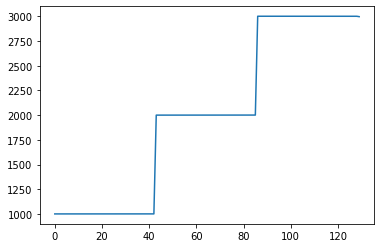

In [517]:
plt.plot(f0)